In [63]:
#import libraries 
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from skopt.space import Integer, Categorical, Real
from skopt import BayesSearchCV
from sklearn.feature_selection import RFE
import shap
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#load data
mydata = pd.read_csv('merged_data.csv')

In [3]:
#look at data
mydata


,Unnamed: 0,Year,Month,ISHMT,discharge_rate,date,County,PM2.5,PM10
0,0,2020,6,Acute upper respiratory infections & influenza...,0.020226,2020-06-01,Cork,2.449595,4.925600
1,1,2020,7,Acute upper respiratory infections & influenza...,0.023597,2020-07-01,Cork,2.918698,8.976464
2,2,2020,8,Acute upper respiratory infections & influenza...,0.038767,2020-08-01,Cork,5.503203,11.047632
3,3,2020,9,Acute upper respiratory infections & influenza...,0.062364,2020-09-01,Cork,5.348747,11.373366
4,4,2020,10,Acute upper respiratory infections & influenza...,0.038767,2020-10-01,Cork,6.587163,12.050000
...,...,...,...,...,...,...,...,...,...
597,597,2023,8,Pneumonia (J12-J18),0.190482,2023-08-01,Dublin,4.065971,8.849873
598,598,2023,9,Pneumonia (J12-J18),0.179160,2023-09-01,Dublin,7.197300,13.106326
599,599,2023,10,Pneumonia (J12-J18),0.238436,2023-10-01,Dublin,6.902304,13.438059
600,600,2023,11,Pneumonia (J12-J18),0.265743,2023-11-01,Dublin,7.755754,13.776940


In [4]:
#drop first col not needed
mydata.drop(mydata.columns[0], axis=1, inplace=True)
mydata

,Year,Month,ISHMT,discharge_rate,date,County,PM2.5,PM10
0,2020,6,Acute upper respiratory infections & influenza...,0.020226,2020-06-01,Cork,2.449595,4.925600
1,2020,7,Acute upper respiratory infections & influenza...,0.023597,2020-07-01,Cork,2.918698,8.976464
2,2020,8,Acute upper respiratory infections & influenza...,0.038767,2020-08-01,Cork,5.503203,11.047632
3,2020,9,Acute upper respiratory infections & influenza...,0.062364,2020-09-01,Cork,5.348747,11.373366
4,2020,10,Acute upper respiratory infections & influenza...,0.038767,2020-10-01,Cork,6.587163,12.050000
...,...,...,...,...,...,...,...,...
597,2023,8,Pneumonia (J12-J18),0.190482,2023-08-01,Dublin,4.065971,8.849873
598,2023,9,Pneumonia (J12-J18),0.179160,2023-09-01,Dublin,7.197300,13.106326
599,2023,10,Pneumonia (J12-J18),0.238436,2023-10-01,Dublin,6.902304,13.438059
600,2023,11,Pneumonia (J12-J18),0.265743,2023-11-01,Dublin,7.755754,13.776940


## Random Forest
#### Build for mydata_pre_feb2022 (up to the end of the COVID restrictions)
##### Baseline model

In [5]:
#convert categorical variables
mydata_2022_encoded = pd.get_dummies(mydata, columns=['ISHMT', 'County'], drop_first=False)

#split data into covid and post-covid
mydata_pre_feb2022 = mydata_2022_encoded[mydata_2022_encoded['date']<'2022-02-01']
mydata_post_feb2022 = mydata_2022_encoded[mydata_2022_encoded['date']>='2022-02-01']

In [6]:
mydata_model = mydata_pre_feb2022
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Random Forest RMSE: 0.04
R²: 0.7837887348169972
MAE: 0.023736301103190468
Cross-Validated R² Scores: [0.79558032 0.43423595 0.63990512 0.71334325 0.49485611]
Mean CV R²: 0.6155841481079692
Feature importances:
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.192138
Month                                                                          0.183399
ISHMT_Pneumonia (J12-J18)                                                      0.162216
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.106906
PM10                                                                           0.071203
PM2.5                                                                          0.062699
County_Dublin                                                                  0.041449
Year                                                                           0.039617
ISHMT_Other diseases of the respiratory system (J60-J99)                       0.03701

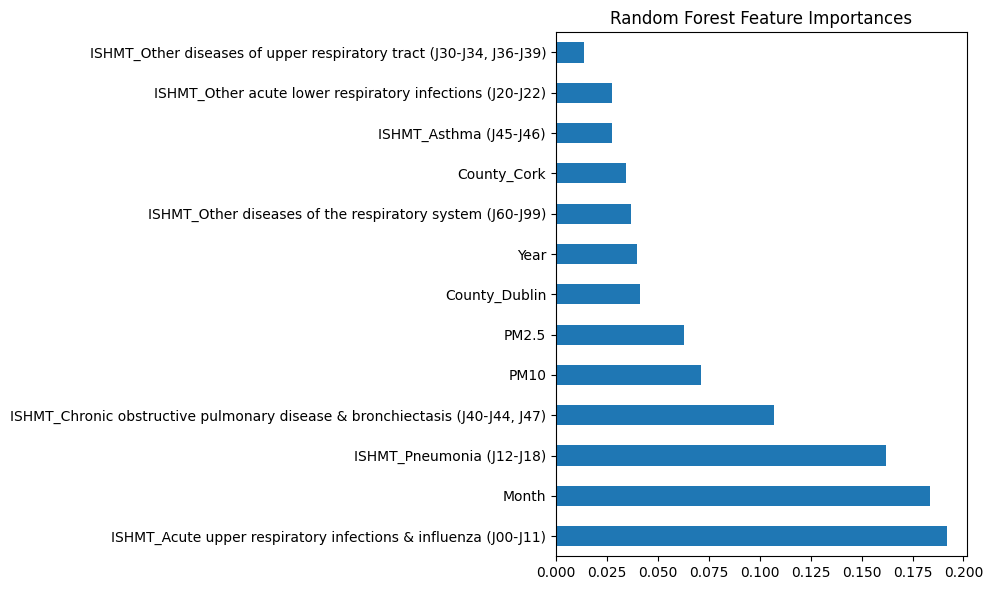

Selected features: Index(['Month', 'PM2.5', 'PM10',
       'ISHMT_Acute upper respiratory infections & influenza (J00-J11)',
       'ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)',
       'ISHMT_Other diseases of the respiratory system (J60-J99)',
       'ISHMT_Pneumonia (J12-J18)', 'County_Dublin'],
      dtype='object')


In [7]:
#build baseline model - random forest model with baseline estimators - and gather stats to compare
results = []

model_covid_base = RandomForestRegressor(n_estimators=250, random_state=42)
model_covid_base.fit(X_train, y_train)
y_pred_rf = model_covid_base.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_covid_base, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_covid_base.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)


#plot feature importances
importances = pd.Series(model_covid_base.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "Model Covid Base",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })

#add RFE
rfe = RFE(estimator=model_covid_base, n_features_to_select=8)  # Select top 5 features
rfe.fit(X_train, y_train)

#get selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
#cross validate 
cv = KFold(n_splits=5)

#rfe(cv) to let the model pick the otimum features (instead of giving it a number I want)
rfecv = RFECV(estimator=model_covid_base,step=2,cv=cv,scoring='neg_mean_absolute_error'  # Or 'r2', 'neg_mean_absolute_error', etc.'neg_mean_squared_error'
)

rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {selected_features.tolist()}")

Optimal number of features: 13
Selected features: ['Year', 'Month', 'PM2.5', 'PM10', 'ISHMT_Acute upper respiratory infections & influenza (J00-J11)', 'ISHMT_Asthma (J45-J46)', 'ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)', 'ISHMT_Other acute lower respiratory infections (J20-J22)', 'ISHMT_Other diseases of the respiratory system (J60-J99)', 'ISHMT_Other diseases of upper respiratory tract (J30-J34, J36-J39)', 'ISHMT_Pneumonia (J12-J18)', 'County_Cork', 'County_Dublin']


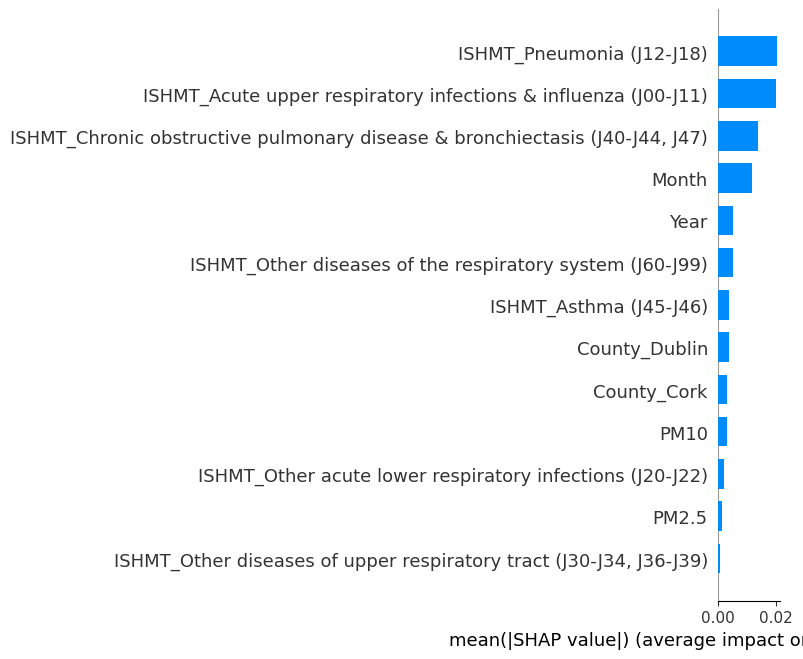

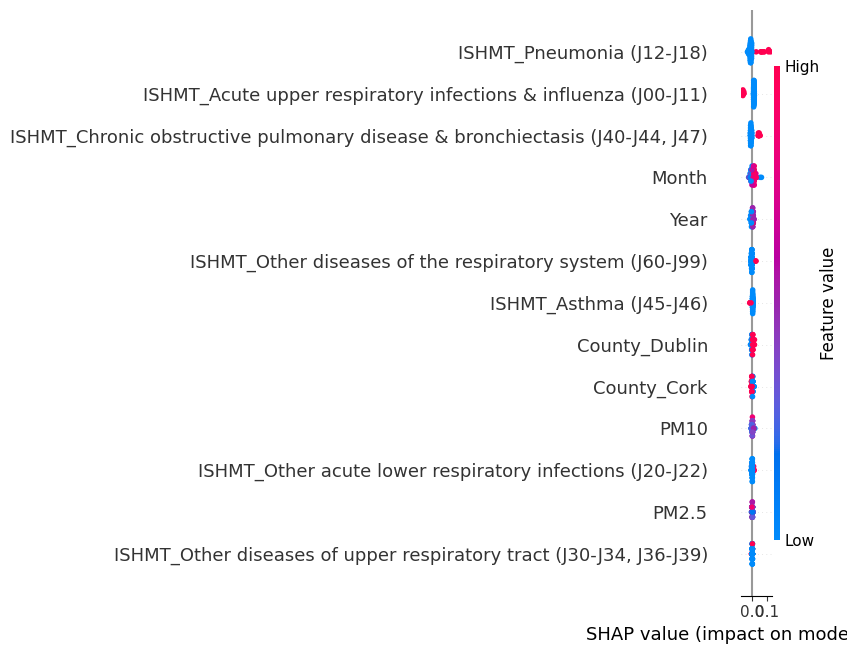

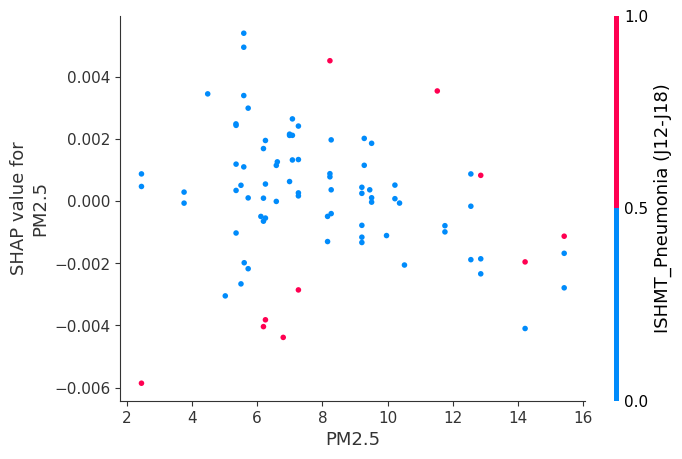

In [9]:
#add SHAP analysis for impact and importance for during COVID 
explainer = shap.TreeExplainer(model_covid_base)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

#plot
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("PM2.5", shap_values, X_test)

##### Gridsearch

In [10]:
#tume hyperparameters - use Gridsearch
param_grid = {
    'n_estimators': [50, 100, 500],  
    'max_depth': [None, 10, 30, 50], 
    'min_samples_split': [2, 10, 20], 
    'min_samples_leaf': [1, 5, 10],   
    'max_features': ['none', 'sqrt', 'log2']  
}
model_covid_grid = RandomForestRegressor(random_state=42)

#grid Search with Cross-validation
grid_search = GridSearchCV(estimator=model_covid_grid, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#print best hyperparameters and look at metrics
print("Best Hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)

mae_rf_grid = mean_absolute_error(y_test, y_pred_grid)
r2_rf_grid =  r2_score(y_test, y_pred_grid)
rmse_rf_grid = mean_squared_error(y_test, y_pred_grid, squared=False)
print("R² Score:",r2_rf_grid)
print("RMSE:",rmse_rf_grid )
print("MAE:", mae_rf_grid)

#r2 scores across CV folds
cv_r2_scores_grid = cross_val_score(model_covid_grid, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_grid)
print("Mean CV R²:", np.mean(cv_r2_scores_grid))

results.append({
        'Model': "Model Covid Grid",
        'R-squared': r2_rf_grid,
        'RMSE':rmse_rf_grid,
        'MAE':mae_rf_grid,
        'Mean CV R²': np.mean(cv_r2_scores_grid)
    })


#add RFE (not sure if 8 is optimal or not!)
rfe = RFE(estimator=model_covid_grid, n_features_to_select=8) 
rfe.fit(X_train, y_train)

#get selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_co

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R² Score: 0.7474348876134393
RMSE: 0.040545846039641065
MAE: 0.02581771184760508
Cross-Validated R² Scores: [0.79661733 0.43059765 0.63642396 0.72344989 0.50767162]
Mean CV R²: 0.6189520885379245
Selected features: Index(['Month', 'PM2.5', 'PM10',
       'ISHMT_Acute upper respiratory infections & influenza (J00-J11)',
       'ISHMT_Asthma (J45-J46)',
       'ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)',
       'ISHMT_Pneumonia (J12-J18)', 'County_Dublin'],
      dtype='object')


Feature importances:
ISHMT_Pneumonia (J12-J18)                                                      0.186267
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.159253
Month                                                                          0.129672
PM10                                                                           0.098326
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.094592
PM2.5                                                                          0.092198
ISHMT_Asthma (J45-J46)                                                         0.041104
Year                                                                           0.038800
County_Cork                                                                    0.037530
County_Dublin                                                                  0.034051
ISHMT_Other diseases of the respiratory system (J60-J99)                       0.032954
ISHMT_Other

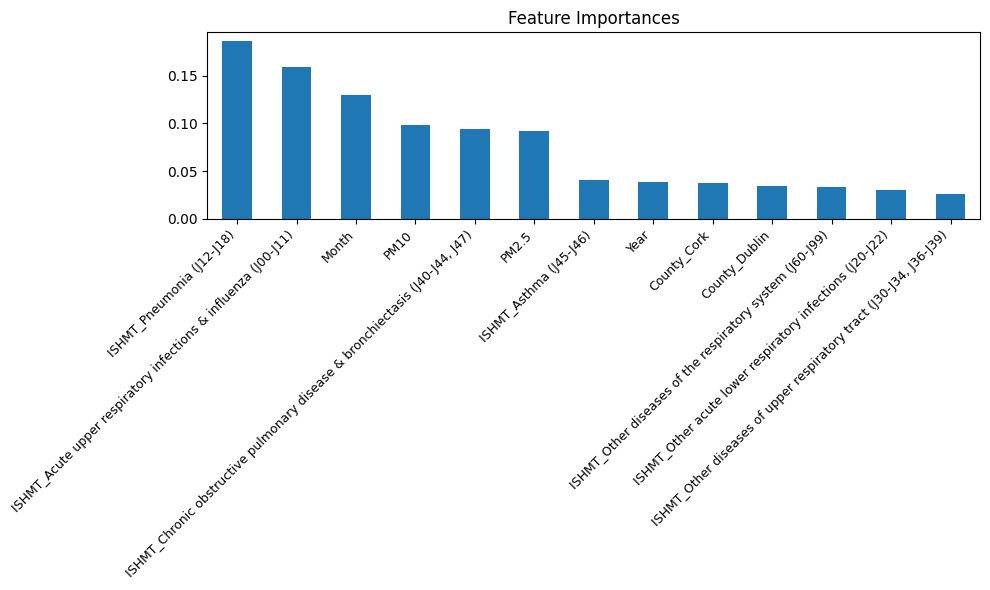

In [11]:
#get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)
feat_importances.plot(kind='bar', figsize=(10,6), title='Feature Importances')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()


##### Baysian Optimiser

In [12]:
#tune hyperparameters in this model use baysian optimiser second
model_covid_bayes = RandomForestRegressor(random_state=42)

#define hyperparameters
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical(['sqrt', 'log2', None, 0.5, 0.75])
}

#add in baysian optimiser for hyperparameter selection
opt = BayesSearchCV(
    estimator=model_covid_bayes,
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fit the searched optimal hyperparameters
opt.fit(X_train, y_train)

#best hyperparameters
print("Best Hyperparameters:", opt.best_params_)
model_covid_bayes = opt.best_estimator_

#predict
y_pred_bayes = model_covid_bayes.predict(X_test)

mae_rf_bayes = mean_absolute_error(y_test, y_pred_bayes)
r2_rf_bayes =  r2_score(y_test, y_pred_bayes)
rmse_rf_bayes = mean_squared_error(y_test, y_pred_bayes, squared=False)
#print
print("R² Score:",r2_rf_bayes)
print("RMSE:",rmse_rf_bayes )
print("MAE:", mae_rf_bayes)

#r2 scores across CV folds
cv_r2_scores_bayes = cross_val_score(model_covid_bayes, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_bayes)
print("Mean CV R²:", np.mean(cv_r2_scores_bayes))

results.append({
        'Model': "Model Covid Bayes",
        'R-squared': r2_rf_bayes,
        'RMSE':rmse_rf_bayes,
        'MAE':mae_rf_bayes,
        'Mean CV R²':  np.mean(cv_r2_scores_bayes)
    })

#add RFE
rfe = RFE(estimator=model_covid_bayes, n_features_to_select=8)  # Select top 5 features
rfe.fit(X_train, y_train)

#get selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Feature importances:
ISHMT_Pneumonia (J12-J18)                                                      0.179691
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.176006
Month                                                                          0.144783
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.106380
PM2.5                                                                          0.087082
PM10                                                                           0.080754
County_Cork                                                                    0.043329
County_Dublin                                                                  0.042153
ISHMT_Asthma (J45-J46)                                                         0.035722
ISHMT_Other diseases of the respiratory system (J60-J99)                       0.033745
Year                                                                           0.030969
ISHMT_Other

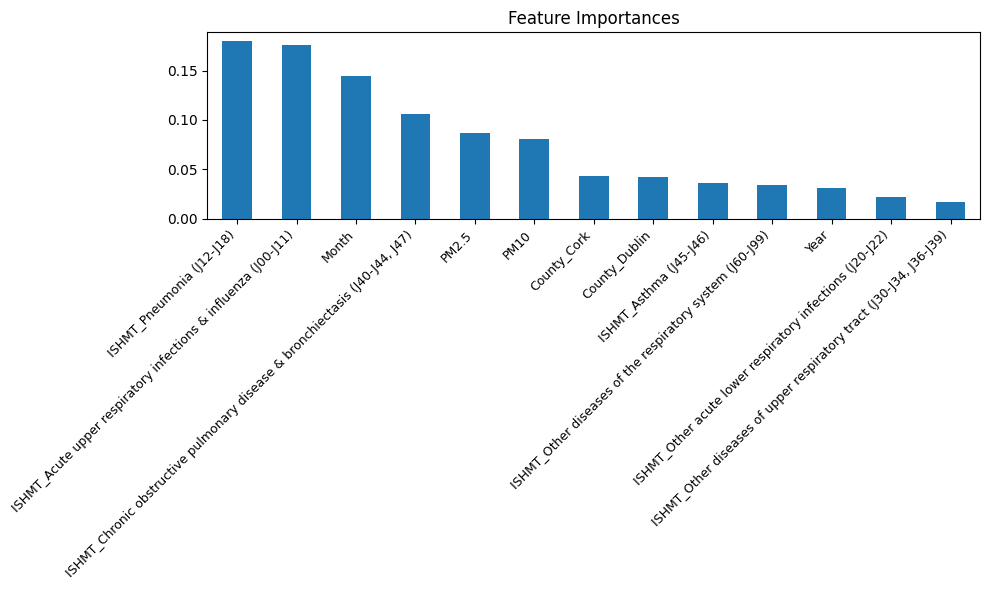

In [13]:
#get feature importances
importances = model_covid_bayes.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)
feat_importances.plot(kind='bar', figsize=(10,6), title='Feature Importances')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

In [14]:
#tune hyperparameters in this model use baysian optimiser second
model_covid_bayes = RandomForestRegressor(random_state=42)

#define hyperparameters
param_space = {
    'n_estimators': Integer(200, 500),
    'max_depth': Integer(10, 40),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2', None])
}

#add in baysian optimiser for hyperparameter selection
opt = BayesSearchCV(
    estimator=model_covid_bayes,
    search_spaces=param_space,
    n_iter=60,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fit the searched optimal hyperparameters
opt.fit(X_train, y_train)

#best hyperparameters
print("Best Hyperparameters:", opt.best_params_)
model_covid_bayes = opt.best_estimator_

#predict
y_pred_bayes = model_covid_bayes.predict(X_test)
mae_rf_bayes = mean_absolute_error(y_test, y_pred_bayes)
r2_rf_bayes =  r2_score(y_test, y_pred_bayes)
rmse_rf_bayes = mean_squared_error(y_test, y_pred_bayes, squared=False)
#print
print("R² Score:",r2_rf_bayes)
print("RMSE:",rmse_rf_bayes )
print("MAE:", mae_rf_bayes)

#r2 scores across CV folds
cv_r2_scores_bayes = cross_val_score(model_covid_bayes, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_bayes)
print("Mean CV R²:", np.mean(cv_r2_scores_bayes))

results.append({
        'Model': "Model Covid Bayes New",
        'R-squared': r2_rf_bayes,
        'RMSE':rmse_rf_bayes,
        'MAE':mae_rf_bayes,
        'Mean CV R²':  np.mean(cv_r2_scores_bayes)
    })


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [40, 'sqrt', 1, 3, 500] before, using random point [28, 'sqrt', 5, 18, 327]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [40, 'sqrt', 1, 3, 500] before, using random point [39, 'sqrt', 1, 16, 340]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

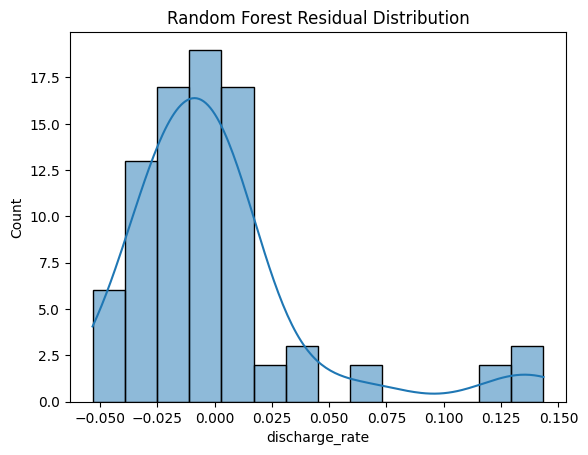

In [15]:
#plot residuals
rf_residuals = y_test - best_rf.predict(X_test)
sns.histplot(rf_residuals, kde=True)
plt.title("Random Forest Residual Distribution")
plt.show()


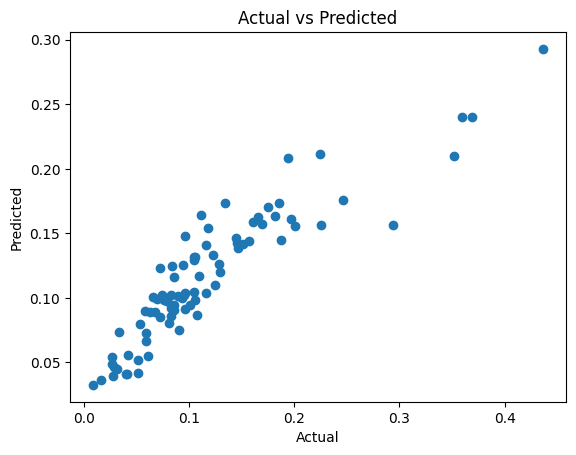

In [16]:
#plot actuals vs predictions
predictions = model_covid_bayes.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

In [17]:
#print predictions
print(predictions)

[0.04165907 0.15401389 0.0984601  0.2117893  0.09854133 0.0325399
 0.12333471 0.09096007 0.12465211 0.14240099 0.0943861  0.14447455
 0.10177578 0.08038585 0.07274654 0.08577761 0.10003752 0.14653207
 0.15742098 0.08986038 0.17333055 0.29287528 0.09735588 0.12970202
 0.09189512 0.10417824 0.08879949 0.10233461 0.12514499 0.24029739
 0.08484468 0.16094786 0.07949807 0.10369163 0.11622623 0.04111152
 0.03938027 0.04513145 0.07493557 0.16253748 0.10192772 0.17595171
 0.13873053 0.1018271  0.16441606 0.14765378 0.12592193 0.05403439
 0.10346041 0.0946141  0.15582339 0.09744423 0.04618279 0.17009425
 0.0886551  0.04105895 0.16334081 0.15607168 0.11666276 0.04904014
 0.11980441 0.11005391 0.13149078 0.14210597 0.0557619  0.03616843
 0.1564619  0.05214873 0.06668014 0.08657392 0.20954738 0.09907852
 0.20818337 0.13195768 0.091425   0.24012511 0.13282782 0.14087847
 0.05510776 0.17378335 0.0732491  0.14410874 0.10045174 0.15902876]


In [18]:
#reduce the model with the more important features
#keep everything with importance of 0.5+ and remodel

mydata_model = mydata_pre_feb2022
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate','County_Dublin','Year','ISHMT_Other diseases of the respiratory system (J60-J99)','ISHMT_Asthma (J45-J46)','ISHMT_Other acute lower respiratory infections (J20-J22)','County_Cork','ISHMT_Other diseases of upper respiratory tract (J30-J34, J36-J39)'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
#print the comparisons
df_results = pd.DataFrame(results)
print(df_results)

                   Model  R-squared      RMSE       MAE  Mean CV R²
0       Model Covid Base   0.783789  0.037514  0.023736    0.615584
1       Model Covid Grid   0.747435  0.040546  0.025818    0.618952
2      Model Covid Bayes   0.776682  0.038126  0.024676    0.632344
3  Model Covid Bayes New   0.746662  0.040608  0.025865    0.626649


##### Reduced Model

Random Forest RMSE: 0.05
R²: 0.5765571842697612
MAE: 0.035903579405102345
Cross-Validated R² Scores: [ 0.48357503 -0.0844896   0.31546765  0.26934264  0.29504292]
Mean CV R²: 0.25578772881210404
Feature importances:
Month                                                                          0.211529
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.211184
ISHMT_Pneumonia (J12-J18)                                                      0.182663
PM10                                                                           0.143592
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.129246
PM2.5                                                                          0.121786
dtype: float64


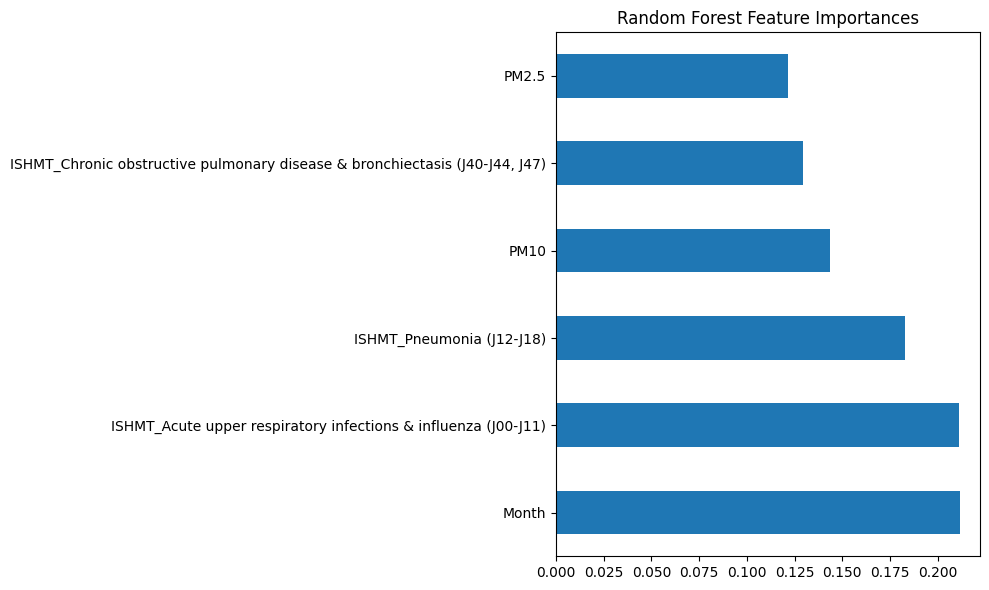

In [20]:
#reduced model using the baseline as it was the best - random forest model with baseline estimators

model_covid_base_red = RandomForestRegressor(n_estimators=250, random_state=42)
model_covid_base_red.fit(X_train, y_train)
y_pred_rf = model_covid_base_red.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_covid_base_red, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_covid_base_red.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)


#plot feature importances
importances = pd.Series(model_covid_base_red.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "Model Covid Base reduced",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })



In [21]:
#print the comparisons
df_results = pd.DataFrame(results)
print(df_results)

                      Model  R-squared      RMSE       MAE  Mean CV R²
0          Model Covid Base   0.783789  0.037514  0.023736    0.615584
1          Model Covid Grid   0.747435  0.040546  0.025818    0.618952
2         Model Covid Bayes   0.776682  0.038126  0.024676    0.632344
3     Model Covid Bayes New   0.746662  0.040608  0.025865    0.626649
4  Model Covid Base reduced   0.576557  0.052500  0.035904    0.255788


Random Forest RMSE: 0.05
R²: 0.5765571842697612
MAE: 0.035903579405102345
Cross-Validated R² Scores: [ 0.48357503 -0.0844896   0.31546765  0.26934264  0.29504292]
Mean CV R²: 0.25578772881210404
Feature importances:
Month                                                                          0.211529
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.211184
ISHMT_Pneumonia (J12-J18)                                                      0.182663
PM10                                                                           0.143592
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.129246
PM2.5                                                                          0.121786
dtype: float64
Selected features: Index(['Month', 'PM2.5', 'PM10',
       'ISHMT_Acute upper respiratory infections & influenza (J00-J11)',
       'ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)',
       'ISHMT_Pneumonia (J12-J

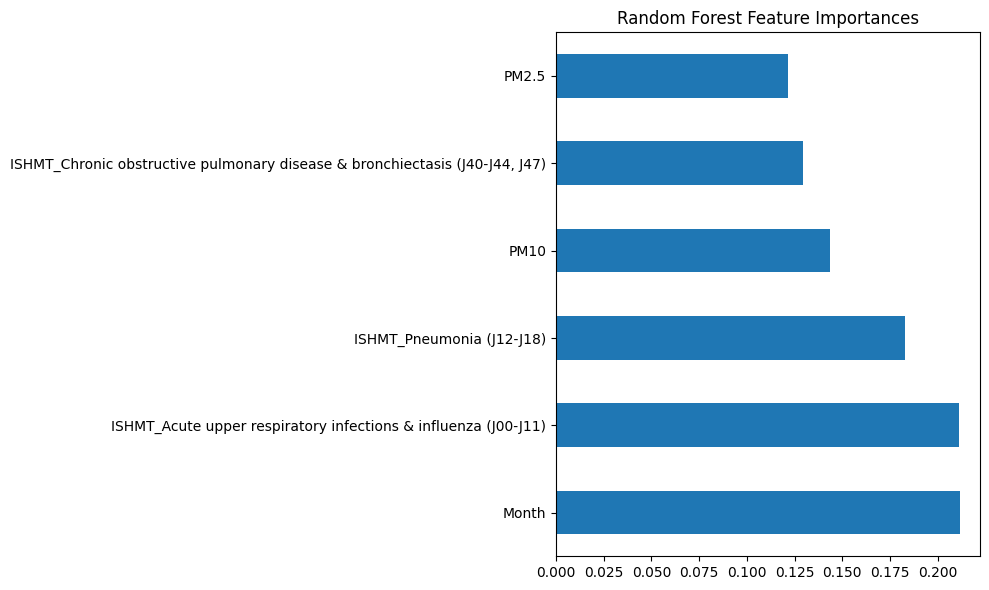

In [22]:

model_covid_base = RandomForestRegressor(n_estimators=250, random_state=42)
model_covid_base.fit(X_train, y_train)
y_pred_rf = model_covid_base.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_covid_base, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_covid_base.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)

#add RFE
rfe = RFE(estimator=model_covid_base, n_features_to_select=8)  # Select top 5 features
rfe.fit(X_train, y_train)

#get selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

#plot feature importances
importances = pd.Series(model_covid_base.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "Model Covid Base RFE",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })



In [23]:
#reduce the model with the more important features
#keep everything with importance of 0.5+ and remodel

mydata_model = mydata_pre_feb2022
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate','County_Cork','ISHMT_Asthma (J45-J46)','ISHMT_Other acute lower respiratory infections (J20-J22)'])
y = mydata_model['discharge_rate']


#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Random Forest RMSE: 0.04
R²: 0.7140019485389211
MAE: 0.02715189727734409
Cross-Validated R² Scores: [0.64302879 0.33215926 0.50943697 0.66222226 0.47884727]
Mean CV R²: 0.5251389093579386
Feature importances:
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.196511
Month                                                                          0.188861
ISHMT_Pneumonia (J12-J18)                                                      0.173207
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.121140
County_Dublin                                                                  0.079447
PM10                                                                           0.077309
PM2.5                                                                          0.071983
ISHMT_Other diseases of the respiratory system (J60-J99)                       0.040998
Year                                                                           0.037210

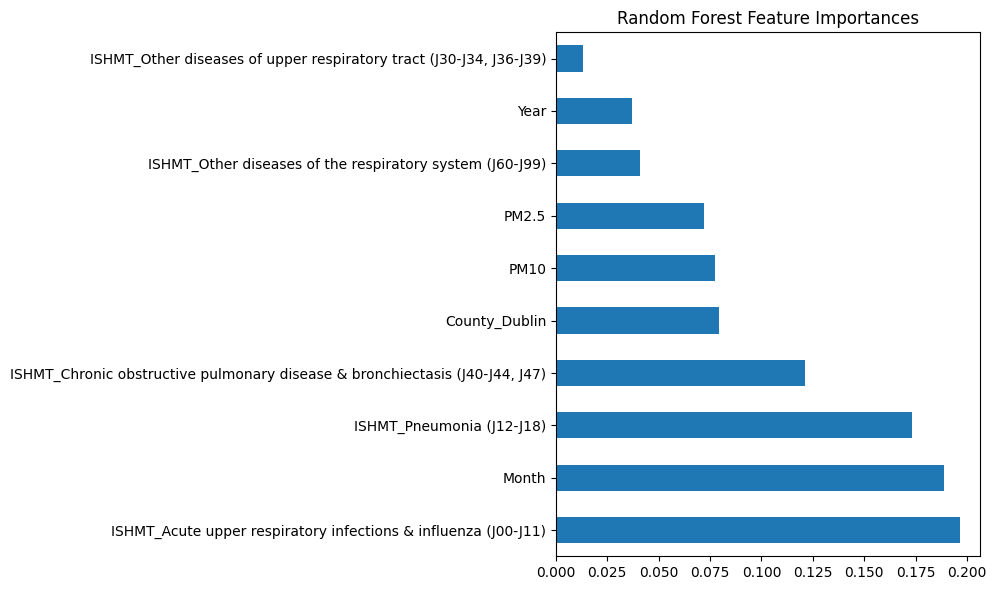

In [24]:
#ne wrducedmodel
model_covid_red = RandomForestRegressor(n_estimators=250, random_state=42)
model_covid_red.fit(X_train, y_train)
y_pred_rf = model_covid_red.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_covid_red, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_covid_red.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)

#add RFE
rfe = RFE(estimator=model_covid_red, n_features_to_select=8)  # Select top 5 features
rfe.fit(X_train, y_train)

#get selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

#plot feature importances
importances = pd.Series(model_covid_red.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "model_covid_red rfe",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })



In [25]:
#print the comparisons
df_results = pd.DataFrame(results)
print(df_results)

                      Model  R-squared      RMSE       MAE  Mean CV R²
0          Model Covid Base   0.783789  0.037514  0.023736    0.615584
1          Model Covid Grid   0.747435  0.040546  0.025818    0.618952
2         Model Covid Bayes   0.776682  0.038126  0.024676    0.632344
3     Model Covid Bayes New   0.746662  0.040608  0.025865    0.626649
4  Model Covid Base reduced   0.576557  0.052500  0.035904    0.255788
5      Model Covid Base RFE   0.576557  0.052500  0.035904    0.255788
6       model_covid_red rfe   0.714002  0.043146  0.027152    0.525139


#### Build for mydata_post_feb2022 (up to the end of the COVID restrictions)
##### Baseline Model

Random Forest RMSE: 0.03
R²: 0.718238095578926
MAE: 0.021037604233814445
Cross-Validated R² Scores: [0.76070386 0.83605134 0.80218761 0.60971173 0.66741992]
Mean CV R²: 0.7352148916266905
Feature importances:
Month                                                                          0.249157
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.141729
ISHMT_Pneumonia (J12-J18)                                                      0.139312
ISHMT_Other acute lower respiratory infections (J20-J22)                       0.112628
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.064570
PM2.5                                                                          0.061077
PM10                                                                           0.044094
County_Cork                                                                    0.037117
ISHMT_Asthma (J45-J46)                                                         0.037097

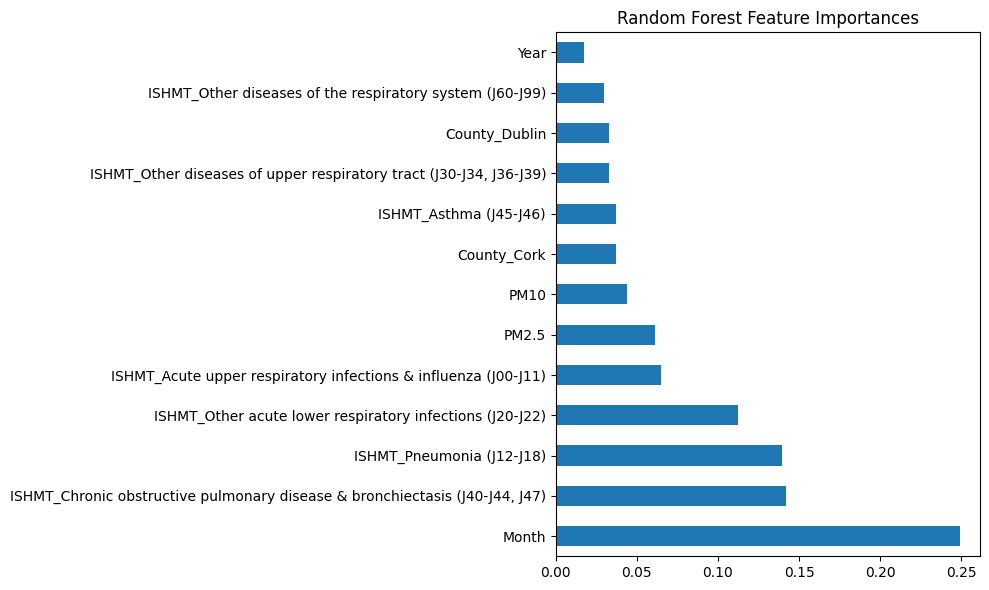

In [26]:
#use base as it seems to be best from previous modelling
mydata_model = mydata_post_feb2022
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results = []

model_post_covid_base = RandomForestRegressor(n_estimators=250, random_state=42)
model_post_covid_base.fit(X_train, y_train)
y_pred_rf = model_post_covid_base.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_post_covid_base, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_post_covid_base.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)


#plot feature importances
importances = pd.Series(model_post_covid_base.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "Model Post Covid Base",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })



##### Gridsearch

In [27]:
#tume hyperparameters - use Gridsearch first
param_grid = {
    'n_estimators': [50, 100, 500],  # Number of trees
    'max_depth': [None, 10, 30, 50],  # Max depth of trees
    'min_samples_split': [2, 10, 20],  # Min samples required to split
    'min_samples_leaf': [1, 5, 10],    # Min samples required at leaf node
    'max_features': ['none', 'sqrt', 'log2']  # Feature selection per split
}
model_post_covid_grid = RandomForestRegressor(random_state=42)

#grid Search with Cross-validation
grid_search = GridSearchCV(estimator=model_post_covid_grid, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#print best hyperparameters and look at metrics
print("Best Hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)

mae_rf_grid = mean_absolute_error(y_test, y_pred_grid)
r2_rf_grid =  r2_score(y_test, y_pred_grid)
rmse_rf_grid = mean_squared_error(y_test, y_pred_grid, squared=False)
print("R² Score:",r2_rf_grid)
print("RMSE:",rmse_rf_grid )
print("MAE:", mae_rf_grid)

#r2 scores across CV folds
cv_r2_scores_grid = cross_val_score(model_post_covid_grid, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_grid)
print("Mean CV R²:", np.mean(cv_r2_scores_grid))

results.append({
        'Model': "Model Post Covid Grid",
        'R-squared': r2_rf_grid,
        'RMSE':rmse_rf_grid,
        'MAE':mae_rf_grid,
        'Mean CV R²': np.mean(cv_r2_scores_grid)
    })




Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_con

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R² Score: 0.6933261699738449
RMSE: 0.03462182521847483
MAE: 0.022703604907604785
Cross-Validated R² Scores: [0.75675143 0.83093227 0.79968399 0.61233039 0.66206065]
Mean CV R²: 0.7323517443366224


##### Baysian Optimiser

In [28]:
#tune hyperparameters in this model use baysian optimiser second
model_post_covid_bayes = RandomForestRegressor(random_state=42)

#define hyperparameters
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical(['sqrt', 'log2', None, 0.5, 0.75])
}

#add in baysian optimiser for hyperparameter selection
opt = BayesSearchCV(
    estimator=model_post_covid_bayes,
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fit the searched optimal hyperparameters
opt.fit(X_train, y_train)

#best hyperparameters
print("Best Hyperparameters:", opt.best_params_)
model_post_covid_bayes = opt.best_estimator_

#predict
y_pred_bayes = model_post_covid_bayes.predict(X_test)

mae_rf_bayes = mean_absolute_error(y_test, y_pred_bayes)
r2_rf_bayes =  r2_score(y_test, y_pred_bayes)
rmse_rf_bayes = mean_squared_error(y_test, y_pred_bayes, squared=False)
#print
print("R² Score:",r2_rf_bayes)
print("RMSE:",rmse_rf_bayes )
print("MAE:", mae_rf_bayes)

#r2 scores across CV folds
cv_r2_scores_bayes = cross_val_score(model_post_covid_bayes, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_bayes)
print("Mean CV R²:", np.mean(cv_r2_scores_bayes))

results.append({
        'Model': "Model Post Covid Bayes",
        'R-squared': r2_rf_bayes,
        'RMSE':rmse_rf_bayes,
        'MAE':mae_rf_bayes,
        'Mean CV R²':  np.mean(cv_r2_scores_bayes)
    })


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [29]:
#print the comparisons
df_results = pd.DataFrame(results)
print(df_results)

                    Model  R-squared      RMSE       MAE  Mean CV R²
0   Model Post Covid Base   0.718238  0.033186  0.021038    0.735215
1   Model Post Covid Grid   0.693326  0.034622  0.022704    0.732352
2  Model Post Covid Bayes   0.713311  0.033475  0.020847    0.734583


#### Don't split data
##### Baseline Model

Random Forest RMSE: 0.04
R²: 0.683095573723276
MAE: 0.02628135767370167
Cross-Validated R² Scores: [0.71402138 0.70014106 0.72932284 0.8380436  0.68191036]
Mean CV R²: 0.7326878475500319
Feature importances:
Month                                                                          0.183608
Year                                                                           0.143609
ISHMT_Pneumonia (J12-J18)                                                      0.122413
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.122170
ISHMT_Acute upper respiratory infections & influenza (J00-J11)                 0.113281
PM2.5                                                                          0.070160
ISHMT_Other acute lower respiratory infections (J20-J22)                       0.064286
PM10                                                                           0.041239
County_Dublin                                                                  0.040369


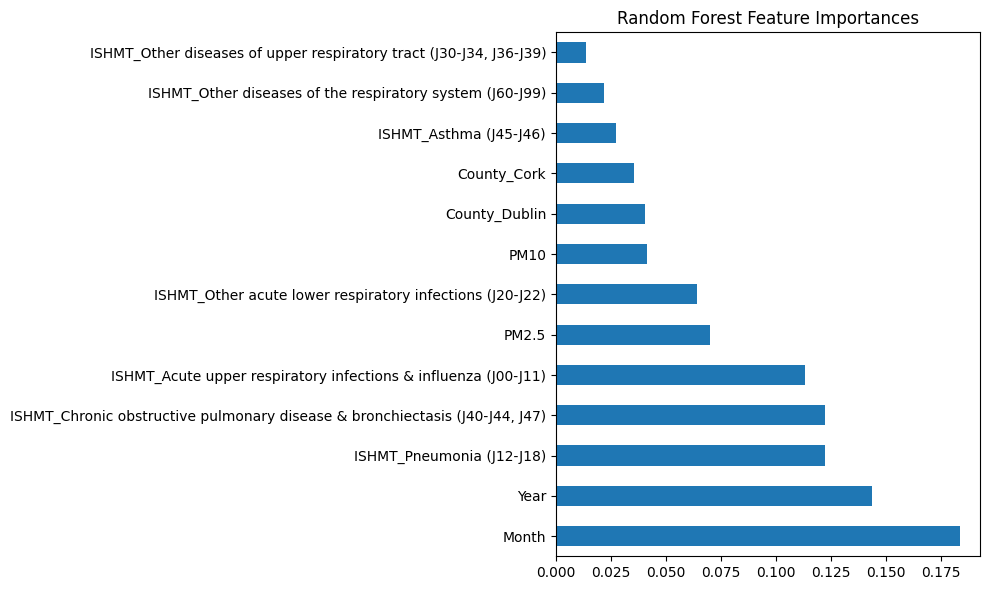

In [30]:
#use base as it seems to be best from previous modelling
mydata_model = mydata_2022_encoded
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results = []

model_full_base = RandomForestRegressor(n_estimators=250, random_state=42)
model_full_base.fit(X_train, y_train)
y_pred_rf = model_full_base.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("R²:", r2_rf)
print("MAE:", mae_rf)

#r2 scores across CV folds
cv_r2_scores = cross_val_score(model_full_base, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))

#get feature importances
importances = model_full_base.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

#print & plot
print("Feature importances:")
print(feat_importances)


#plot feature importances
importances = pd.Series(model_full_base.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

results.append({
        'Model': "Model Full Data",
        'R-squared': r2_rf,
        'RMSE':rmse_rf,
        'MAE':mae_rf,
        'Mean CV R²': np.mean(cv_r2_scores)
    })



##### Gridsearch

In [31]:
#tume hyperparameters - use Gridsearch first
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],  
    'max_features': ['none', 'sqrt', 'log2'] 
}
model_full_grid = RandomForestRegressor(random_state=42)

#grid Search with Cross-validation
grid_search = GridSearchCV(estimator=model_full_grid, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#print best hyperparameters and look at metrics
print("Best Hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_grid = best_rf.predict(X_test)

mae_rf_grid = mean_absolute_error(y_test, y_pred_grid)
r2_rf_grid =  r2_score(y_test, y_pred_grid)
rmse_rf_grid = mean_squared_error(y_test, y_pred_grid, squared=False)
print("R² Score:",r2_rf_grid)
print("RMSE:",rmse_rf_grid )
print("MAE:", mae_rf_grid)

#r2 scores across CV folds
cv_r2_scores_grid = cross_val_score(model_full_grid, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_grid)
print("Mean CV R²:", np.mean(cv_r2_scores_grid))

results.append({
        'Model': "Model Full Grid",
        'R-squared': r2_rf_grid,
        'RMSE':rmse_rf_grid,
        'MAE':mae_rf_grid,
        'Mean CV R²': np.mean(cv_r2_scores_grid)
    })




Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
181 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_co

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R² Score: 0.6907866440440528
RMSE: 0.04276690455120795
MAE: 0.02761151940878455
Cross-Validated R² Scores: [0.71348009 0.70073288 0.71517341 0.8188116  0.68046112]
Mean CV R²: 0.7257318186191138


##### Baysian Optimiser

In [32]:
#tune hyperparameters in this model use baysian optimiser second
model_full_bayes = RandomForestRegressor(random_state=42)

#tune hyperparameters in this model use baysian optimiser second
RandomForestRegressor(random_state=42)

#define hyperparameters
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical(['sqrt', 'log2', None, 0.5, 0.75])
}

#add in baysian optimiser for hyperparameter selection
opt = BayesSearchCV(
    estimator=model_full_bayes,
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#fit the searched optimal hyperparameters
opt.fit(X_train, y_train)

#best hyperparameters
print("Best Hyperparameters:", opt.best_params_)
model_full_bayes = opt.best_estimator_

#predict
y_pred_bayes = model_full_bayes.predict(X_test)

mae_rf_bayes = mean_absolute_error(y_test, y_pred_bayes)
r2_rf_bayes =  r2_score(y_test, y_pred_bayes)
rmse_rf_bayes = mean_squared_error(y_test, y_pred_bayes, squared=False)
#print
print("R² Score:",r2_rf_bayes)
print("RMSE:",rmse_rf_bayes )
print("MAE:", mae_rf_bayes)

#r2 scores across CV folds
cv_r2_scores_bayes = cross_val_score(model_full_bayes, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores_bayes)
print("Mean CV R²:", np.mean(cv_r2_scores_bayes))

results.append({
        'Model': "Model Full Bayes",
        'R-squared': r2_rf_bayes,
        'RMSE':rmse_rf_bayes,
        'MAE':mae_rf_bayes,
        'Mean CV R²':  np.mean(cv_r2_scores_bayes)
    })


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [33]:
#print the comparisons
df_results = pd.DataFrame(results)
print(df_results)

              Model  R-squared      RMSE       MAE  Mean CV R²
0   Model Full Data   0.683096  0.043296  0.026281    0.732688
1   Model Full Grid   0.690787  0.042767  0.027612    0.725732
2  Model Full Bayes   0.690919  0.042758  0.025856    0.736866


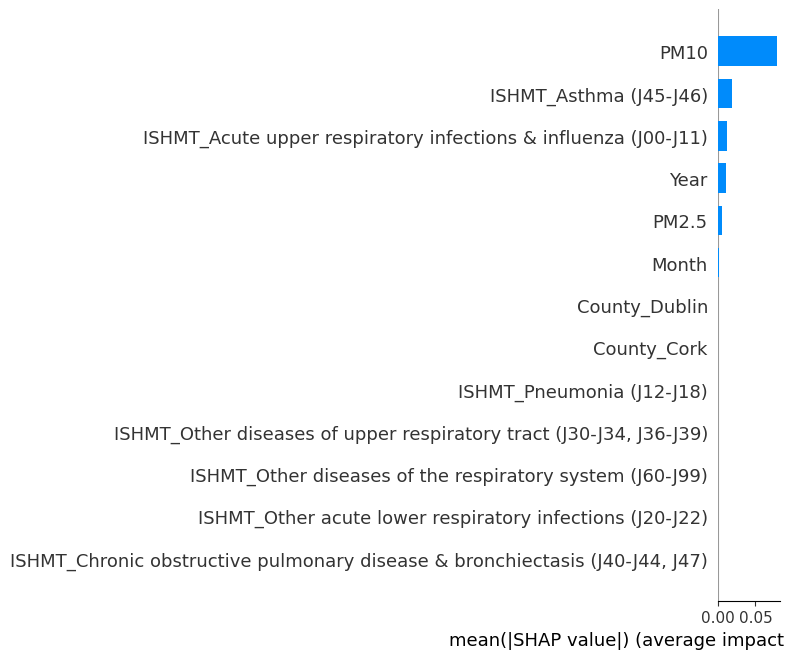

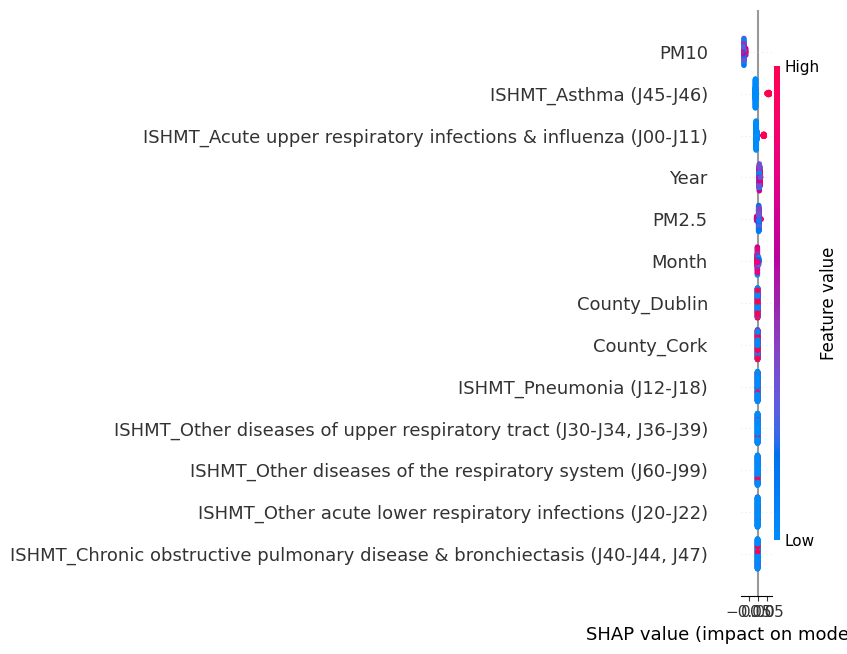

In [34]:
#add SHAP analysis for impact and importance for DURING COVID
explainer = shap.TreeExplainer(model_covid_base)
shap_values = explainer.shap_values(X_test)

#feature importance + plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

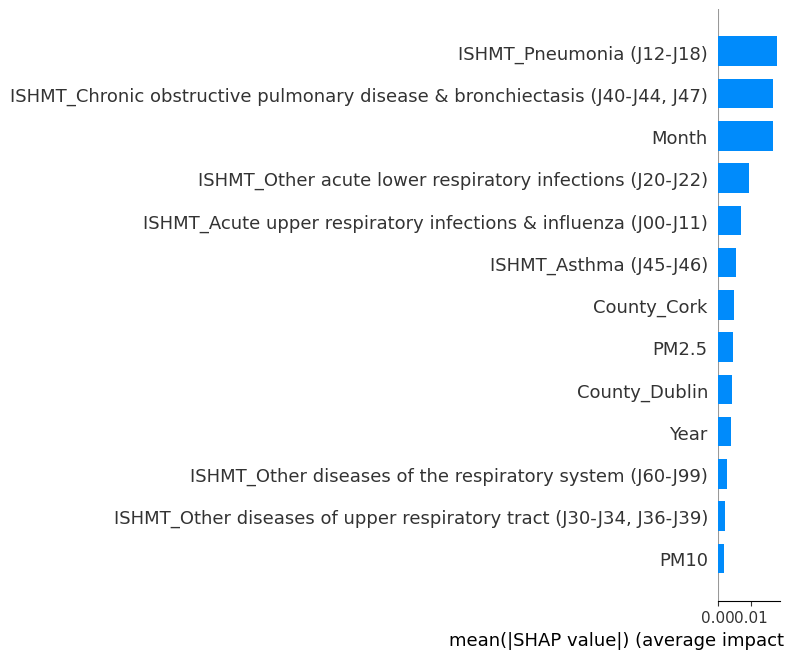

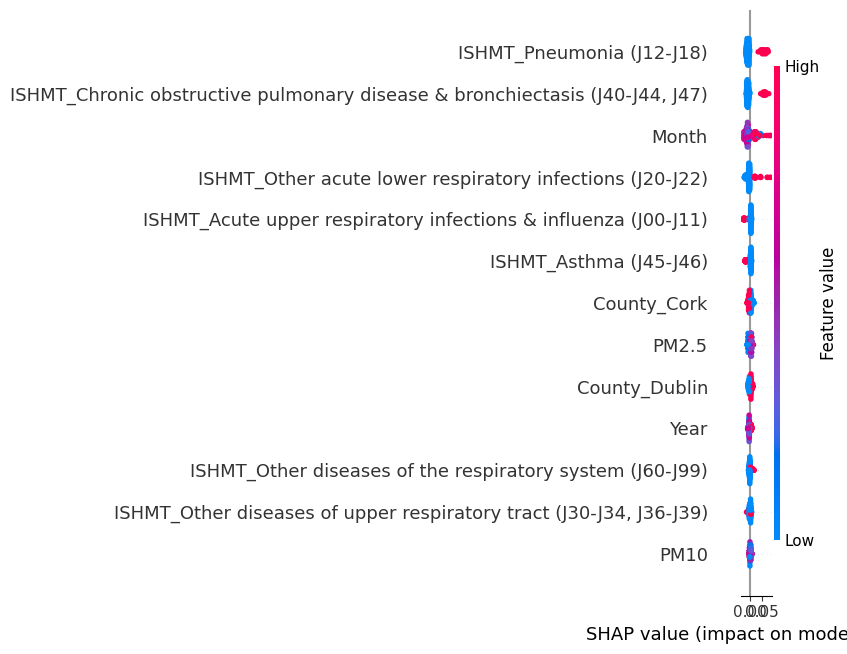

In [35]:
#add SHAP analysis for impact and importance for AFTER COVID
explainer = shap.TreeExplainer(model_post_covid_base)
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Full summary (individual impact)
shap.summary_plot(shap_values, X_test)


C:\Users\lsmyth\AppData\Local\anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


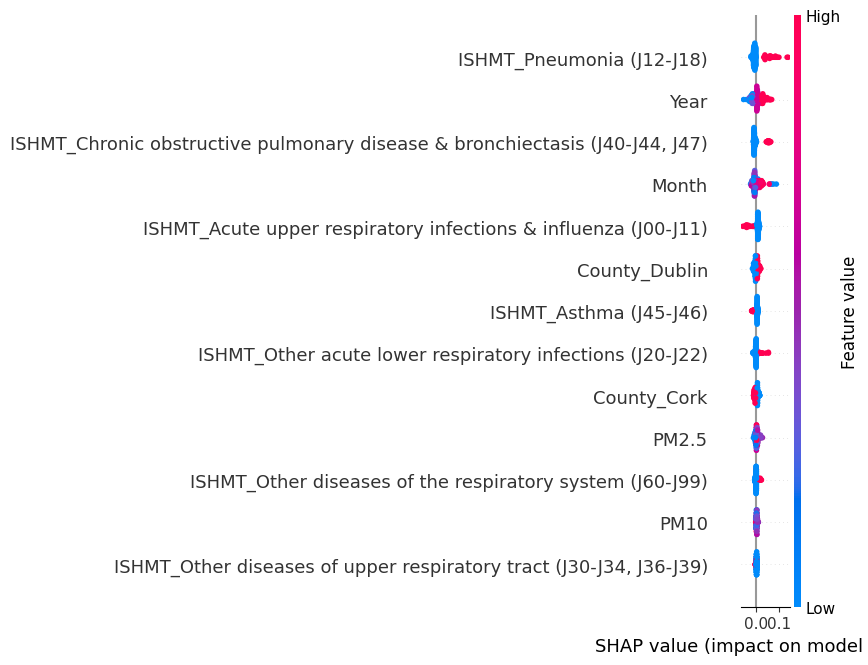

In [61]:
#add SHAP analysis for impact and importance for FULL DATASET
explainer = shap.TreeExplainer(model_full_bayes)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar",show=False )
plt.savefig('shap_weights_bar.png', format='png', bbox_inches='tight')
#plot
shap.summary_plot(shap_values, X_test,show=False )
plt.savefig('shap_weights.png', format='png', bbox_inches='tight')

In [43]:
#rfe(cv) to let the model pick the otimum features (instead of giving it a number I want)
rfecv = RFECV(estimator=model_full_bayes,step=2,cv=cv,scoring='neg_mean_absolute_error'  # Or 'r2', 'neg_mean_absolute_error', etc.'neg_mean_squared_error'
)

rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {selected_features.tolist()}")

Optimal number of features: 13
Selected features: ['Year', 'Month', 'PM2.5', 'PM10', 'ISHMT_Acute upper respiratory infections & influenza (J00-J11)', 'ISHMT_Asthma (J45-J46)', 'ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)', 'ISHMT_Other acute lower respiratory infections (J20-J22)', 'ISHMT_Other diseases of the respiratory system (J60-J99)', 'ISHMT_Other diseases of upper respiratory tract (J30-J34, J36-J39)', 'ISHMT_Pneumonia (J12-J18)', 'County_Cork', 'County_Dublin']


In [68]:
#make 3 colours (middle is a 'neutral' yellow as it is summer)
colour_map = LinearSegmentedColormap.from_list("custom_diverging", ["#d73027", "#ffffbf", "#762a83"])
shap.dependence_plot("PM2.5", shap_values, X_test,interaction_index='Month',title="SHapley Additive exPlanations for PM2.5 by Month",show=False,cmap=colour_map )
plt.savefig('shap_PM2.5_Month.png', format='png', bbox_inches='tight')
plt.close()


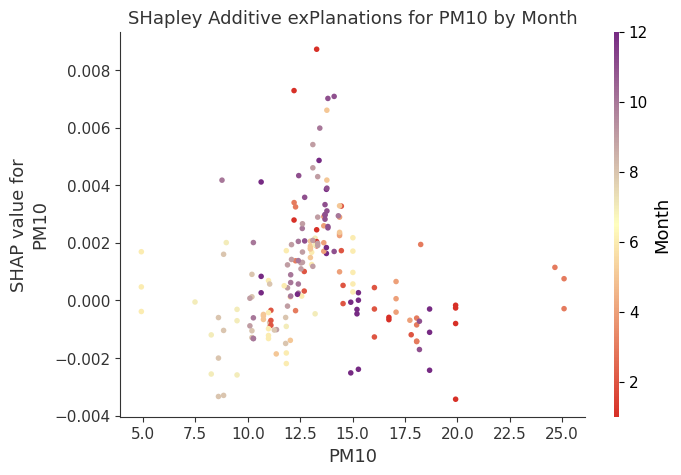

In [67]:

shap.dependence_plot("PM10", shap_values, X_test,interaction_index='Month',title="SHapley Additive exPlanations for PM10 by Month",show=False,cmap=colour_map )
plt.savefig('shap_PM10_Month.png', format='png', bbox_inches='tight')